In [18]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
%reload_ext autoreload

from Funcs import df1_2
import parameters

**Maximum strain rate $S$**

what is $S =  $max($|\frac{\partial v}{\partial y}|$) ?


In [2]:
from pathlib import Path
p = Path('data/vel_field') / 'UVP_CPU_time_2.npy'
N_list, chrono = np.load(p)
N_dat = N_list.size
N_list = N_list.astype(int)

In [3]:
# strain rate placeholder:
S = np.zeros(N_dat)

for i, N in enumerate(N_list):
    dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
    datap = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
    u,v,P = np.load(datap)
    s = np.abs(df1_2(v, dy, axis=1))
    S[i] = np.max(s[0,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
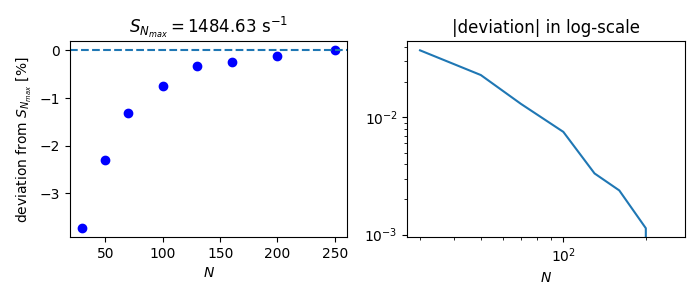

In [5]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(7,3))

# relative deviation from the best estimate of S (i.e. for the highest N):
devi = (S - S[-1]) / S[-1]

ax.plot(N_list, devi * 100, 'bo')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.axhline(0, ls='--')
ax.set_xlabel('$N$')
ax.set_title('$S_{N_{max}} = $' +'${:.2f}$ '.format(S[-1]) + 's$^{-1}$')
ax.set_ylabel('deviation from $S_{N_{max}}$ [%]')

ax2.plot(N_list, np.abs(devi))
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('|deviation| in log-scale')
ax2.set_xlabel('$N$')
plt.tight_layout()

## What is the diffusion zone length?

In [19]:
from species_transport import load_Y_T, save_Y_T
from parameters import Ly

In [20]:
def find_nearest(arr1, arr2):
    """Finds all indices of 1d array 'arr1' corresponding to the values closest to those of 'arr2'."""
    @jit(nopython=True)
    def _find_nearest(arr1, arr2):
        idx = np.zeros(len(arr2))
        for i in range(len(idx)):
            idx[i] = (np.abs(arr1 - arr2[i])).argmin()
        return idx
    return np.array(_find_nearest(arr1, arr2), dtype=int)

In [21]:
def diffzone_thickness(Y):
    """
    Returns the thickness of the zone at the left wall
    between 10% and 90% of Y_N2 at the slot.
    """
    _,N,M = Y.shape
    dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
    
    N2_lwall = Y[2,0,:]
    N2_slot = Y[2,0,0]
    print(N2_slot)
    
    il,ir = find_nearest(N2_lwall, np.array([0.9, 0.1]) * N2_slot)
    thickn = abs(il - ir) * dy
    return thickn, il,ir

0.767
0.767
0.767
0.767
0.767
0.767
0.767
0.767


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
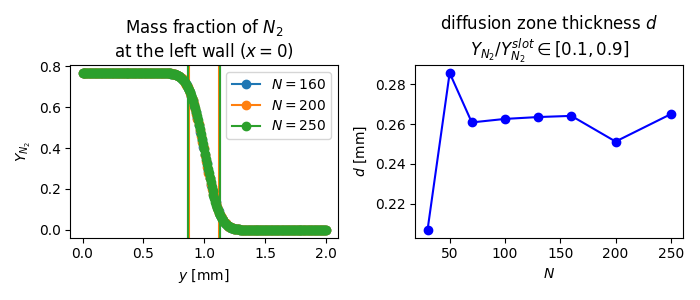

In [22]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(7,3))
ax.set_xlabel('$y$ [mm]')

Thickn = np.zeros(N_list.size)

for i,N in enumerate(N_list):
    p = Path('data/species/test0') / 'N{}.npy'.format(N)
    Y,T = load_Y_T(p)
    dx, dy, _,_ = parameters.set_resolution(N,N)
    y = np.linspace(0, Ly, N)
    N2_lwall = Y[2,0,:]
    Thickn[i], il,ir = diffzone_thickness(Y)
    if N in [160, 200, 250]:
        l, = ax.plot(y * 1e3, N2_lwall, 'o-', label='$N = {}$'.format(N))
        ax.axvline(y[il] * 1e3, color=l.get_color())
        ax.axvline(y[ir] * 1e3, color=l.get_color())
        

ax.set_ylabel('$Y_{N_2}$')
ax.set_title('Mass fraction of $N_2$\nat the left wall ($x=0$)')
ax.legend()
ax2.plot(N_list, Thickn * 1e3, 'bo-')
ax2.set_title('diffusion zone thickness $d$\n$Y_{N_2}/Y_{N_2}^{slot} \in [0.1, 0.9]$')
ax2.set_ylabel('$d$ [mm]')
ax2.set_xlabel('$N$')
plt.tight_layout()
